In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gvar as gv
from tqdm import tqdm
rng = np.random.default_rng()

In [2]:
J = 1
nmax = 10
N = nmax**2

In [3]:
def build_lattice(n=0,m=0):    
    #lattice = rng.choice(spin_select, (n,m), p =[0.5,0.5])    
    return rng.choice([-1,1], (nmax,nmax), p =[0.5,0.5])

In [4]:
def Energy(lattice:np.ndarray)->float:
    spin_bonds = 0
    for i in range(nmax):
        for j in range(nmax):
            s_ij = lattice[i,j]
            if j<nmax-1:
                s_right = lattice[i, j+1] #right neighbor
            else:
                s_right = 0 #right edge of lattice
            if i<nmax-1:
                s_down = lattice[i+1,j] #bottom neighbor
            else:
                s_down = 0 # bottom edge of lattice
            spin_bonds += s_ij * (s_right + s_down)
    
    E = (-J) * spin_bonds/N
    return E

In [5]:
def new_energy(lattice:np.ndarray)->float:
    return -J/N * ( np.sum( lattice[0:nmax-1,:] * lattice[1:nmax,:] ) + np.sum( lattice[:,0:nmax-1] * lattice[:,1:nmax] ) )

In [6]:
def flip_energy(lattice:np.ndarray, flip_location:tuple)->float:
    i,j = flip_location
    s_ij = lattice[i,j]
    
    s_up = lattice[abs(i-1),j] * (i!=0)
    s_down = lattice[(i+1)%nmax,j] * (i!=nmax)   
    s_left = lattice[i,abs(j-1)] * (j!=0)
    s_right = lattice[i,(j+1)%nmax] * (j!=nmax)
   
    neighbors = (s_up + s_down + s_left + s_right)
    flipped_sum = -1 * s_ij * neighbors  # flips the spin
    initial_sum = s_ij * neighbors
    return (-J) * (flipped_sum - initial_sum) /N

In [7]:
def magnetization(lattice:np.ndarray)->float:
    return lattice.sum()/N

In [8]:
for a in range(5):
    print(a)
    #print(b)

0
1
2
3
4


In [9]:
range(5,2)

range(5, 2)

In [10]:
10/12

0.8333333333333334

In [8]:
def spin_corr(lattice:np.ndarray)->float:
    si = magnetization(lattice)
    sisj = np.array([])
    dist = np.array([])
    counts = np.array([])
    for xi in range(len(lattice)):
        for yi in range(len(lattice)):
            for xj in range(len(lattice)):
                for yj in range(len(lattice)):
                    distance = np.sqrt((xi-xj)**2 + (yi-yj)**2)
                    if distance>0:
                        if distance not in dist:
                            dist = np.append(dist,distance)
                            sisj = np.append(sisj, lattice[xi,yi] * lattice[xj,yj])
                            counts = np.append(counts, 1)
                        else:
                            index = np.where(dist == distance)[0][0]
                            counts[index] += 1
                            sisj[index] += lattice[xi,yi] * lattice[xj,yj]
    
                            
                        
        # need to average sisj, but not sure how to get distances to be relevant
    return dist, sisj/counts #-si**2
    #return sisj/N - si**2  # averages <Sij * Sab> over whole array... returns 1 value per MC step, probably wrong.

In [103]:
x, y = spin_corr(build_lattice())

1.0
2.0
3.0
4.0
5.0
6.0
1.4142135623730951
2.23606797749979
3.1622776601683795
4.123105625617661
5.0990195135927845
6.082762530298219
2.8284271247461903
3.605551275463989
4.47213595499958
5.385164807134504
6.324555320336759
4.242640687119285
5.830951894845301
6.708203932499369
5.656854249492381
6.4031242374328485
7.211102550927978
7.0710678118654755
7.810249675906654
8.48528137423857


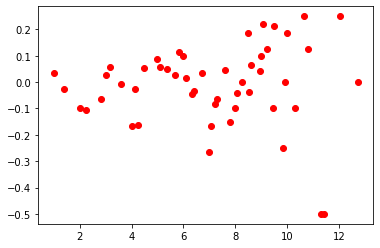

In [59]:
plt.plot(x,y, 'ro')

In [9]:
def mcmc(lattice, beta, nflips, nsteps):
    lattice = lattice.copy()
    energy = Energy(lattice)
    av_energy = np.zeros(nsteps)
    av_mag = np.zeros(nsteps)
    for step in range(nsteps):
        for flip in range(nflips):
            flip_location = tuple(rng.integers(len(lattice),size=2))
            flip_dE = flip_energy(lattice,flip_location)
            if (np.exp(-beta*flip_dE)>rng.random()):
                lattice[flip_location] = -1 * lattice[flip_location]
                energy += flip_dE              
        # record energy and magnetization
        av_energy[step] = energy
        av_mag[step] = magnetization(lattice)
        
    return av_energy, av_mag

In [10]:
def wolff(lattice, beta):
    N = len(lattice)
    i, j = rng.integers(N), rng.integers(N)
    S = lattice[i,j]
    C = [[i,j]]
    F_old = [[i,j]]
    p_accept = 1. - np.exp(-2 * beta)
    while len(F_old) > 0:
        F_new = []
        for i,j in F_old:
            neighbours = [[(i+1) % N,j], [(i-1+N) % N,j], [i,(j+1) % N], [i,(j-1+N) % N]]
            for neighbour in neighbours:
                if lattice[neighbour[0],neighbour[1]] == S and neighbour not in C:
                    if rng.random() < p_accept:
                        F_new.append(neighbour)
                        C.append(neighbour)
        F_old = F_new
    for i,j in C:
        lattice[i,j] *= -1

In [11]:
def imported_wolff(lattice,beta,nsteps):
    measure_step = nsteps/1000
    av_energy = np.zeros(int(nsteps/measure_step))
    av_mag = np.zeros(int(nsteps/measure_step))
    #av_sscorr = np.zeros(int(nsteps/measure_step))
    #av_sscorr = np.zeros(int(nsteps/measure_step))
    for i in range(nsteps):
        wolff(lattice,beta)
        if i%measure_step ==0:
            av_energy[int(i/measure_step)]=new_energy(lattice)
            av_mag[int(i/measure_step)]=magnetization(lattice)
            distance, y =spin_corr(lattice)
            if int(i/measure_step) == 0:
                av_sscorr = np.zeros((int(nsteps/measure_step), len(y)))
            av_sscorr[int(i/measure_step)][:] = y
            #print((i/measure_step)/nsteps)
    return av_energy, av_mag, distance, av_sscorr
    #return av_mag

In [209]:
ew,mw,d,ssc = imported_wolff(build_lattice(), 0.20, 10**4)

In [210]:
len(ew)

1000

In [133]:
ssc

array([[-0.06666667,  0.025     ,  0.02857143, ..., -0.25      ,
         0.        ,  0.        ],
       [ 0.45555556,  0.3125    ,  0.34285714, ...,  0.75      ,
         0.75      ,  1.        ],
       [ 0.48888889,  0.2375    ,  0.18571429, ...,  1.        ,
         1.        ,  1.        ],
       ...,
       [ 0.23333333,  0.1625    , -0.12857143, ..., -0.5       ,
         0.        , -1.        ],
       [ 0.47777778,  0.3       ,  0.24285714, ...,  0.        ,
         0.25      ,  0.        ],
       [ 0.35555556,  0.1375    , -0.1       , ..., -0.5       ,
        -0.25      ,  1.        ]])

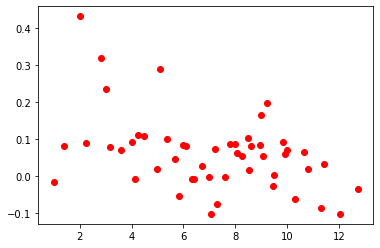

In [125]:
plt.plot(d,[np.mean(ssc[:][i]) for i in range(len(ssc[0][:]))] , 'ro')

In [118]:
observables = {'Energy':ew,'M':mw, "M2":mw**2}
obs_average = gv.dataset.avg_data(observables)
corr = gv.evalcorr(obs_average)

In [189]:
obs_average['Energy'].sdev/N

0.00023787865756889684

In [156]:
corr

BufferDict({('Energy', 'Energy'): array([[1.]]), ('Energy', 'M'): array([[0.05133208]]), ('Energy', 'M2'): array([[-0.62352633]]), ('M', 'Energy'): array([[0.05133208]]), ('M', 'M'): array([[1.]]), ('M', 'M2'): array([[-0.20085566]]), ('M2', 'Energy'): array([[-0.62352633]]), ('M2', 'M'): array([[-0.20085566]]), ('M2', 'M2'): array([[1.]])})

In [106]:
mw.std()/30

0.004700194735918455

In [108]:
ew.std()/30

0.003546442270470193

In [20]:
gv.dataset.autocorr(ew)

array([ 1.00000000e+00,  7.05721120e-01,  5.05160700e-01,  3.66424127e-01,
        2.48009836e-01,  1.58553513e-01,  8.88167169e-02,  7.13910880e-02,
        7.19767034e-02,  6.74146166e-02,  6.31524791e-02,  4.81435849e-02,
        6.11013969e-02,  5.38683325e-02,  4.23702740e-02,  2.89182598e-02,
        2.15652157e-02,  2.50503415e-02,  3.63884270e-02,  3.54400157e-02,
        3.44573245e-02,  4.43727931e-02,  5.97387698e-02,  4.95119253e-02,
        3.59713546e-02,  2.27450165e-02,  1.12412447e-02,  1.61604141e-02,
        1.84657391e-02, -2.23933616e-03, -5.30167620e-03, -1.77195794e-02,
       -3.28513100e-02, -2.16874808e-02, -8.81822527e-03, -1.85080176e-02,
       -2.77693110e-02, -3.06316848e-02, -4.04528835e-02, -1.48086423e-02,
       -2.64212529e-03,  3.46541484e-03,  4.35557882e-02,  4.97176048e-02,
        4.04820215e-02,  2.71042804e-02, -2.35931590e-03, -3.41625171e-02,
       -3.53394613e-02, -4.31609977e-02, -4.57434188e-02, -4.35523602e-02,
       -1.59741598e-02, -

Text(0, 0.5, 'Magnetization')

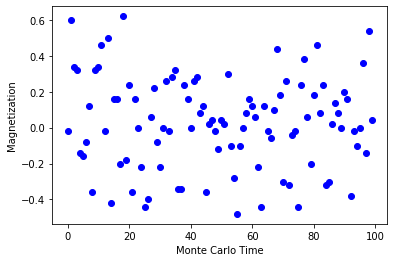

In [193]:
plt.plot(np.arange(len(mw)),mw,'bo')
plt.errorbar(np.arange(len(mw)),mw, yerr=obs_average['M'].sdev/N, fmt='.b')
plt.xlabel("Monte Carlo Time")
plt.ylabel("Magnetization")

Text(0, 0.5, 'Energy')

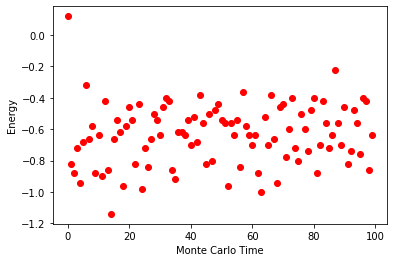

In [196]:
plt.plot(np.arange(len(ew)),(ew),'ro')
plt.errorbar(np.arange(len(ew)),ew, yerr=obs_average['Energy'].sdev/N, fmt='.r')
plt.xlabel("Monte Carlo Time")
plt.ylabel("Energy")

In [12]:
def temp_wolff():
    beta = np.linspace(0.3,0.4,20)
    e_list = np.zeros(len(beta))
    m_list = np.zeros(len(beta))
    chi_list = np.zeros(len(beta))
    f1 = open('mc_energy.txt','a')
    f2 = open('mc_magnetization.txt','a')
    f3 = open('mc_distances.txt','a')
    f4 = open('mc_ssc.txt','a')
    for i in tqdm(range(len(beta))):
        e,m,d,ssc = imported_wolff(build_lattice(),beta[i],10**4)
        np.savetxt(f1,e)
        np.savetxt(f2,m)
        np.savetxt(f3,d)
        np.savetxt(f4,ssc)
        #e_list[i] = np.mean(e)
        #m_list[i] = np.mean(np.abs(m))
        #chi_list[i] = np.mean(m**2) - m_list[i]**2
        
    #return e_list,m_list,chi_list
    f1.close()
    f2.close()
    f3.close()
    f4.close()

In [13]:
temp_wolff()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [20:32<00:00, 61.63s/it]


In [15]:
et = np.loadtxt('mc_energy.txt')

In [16]:
et

array([-0.38, -0.82, -0.62, ..., -1.06, -0.98, -0.84])

In [197]:
f=open('test.txt','r+')

In [198]:
for i in range(3):
    np.savetxt(f, et)

In [199]:
f.close()
#f=open('test.txt','r')
#print(f.read(),"\n")

In [138]:
np.savetxt('test.txt', et)

In [136]:
et

array([-1.1308 , -1.14366, -1.14796, -1.15876, -1.149  , -1.17256,
       -1.17112, -1.18716, -1.1763 , -1.17502, -1.19086, -1.21514,
       -1.21742, -1.22328, -1.21962, -1.23568, -1.25928, -1.2436 ,
       -1.24164, -1.25186, -1.2626 , -1.28288, -1.28168, -1.29044,
       -1.29086, -1.29502, -1.30468, -1.30782, -1.31228, -1.32628,
       -1.33076, -1.33924, -1.33636, -1.3572 , -1.35456, -1.36442,
       -1.36842, -1.36644, -1.37338, -1.39192])

Text(0, 0.5, 'Susceptibility')

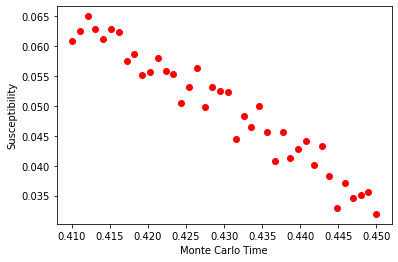

In [180]:
plt.plot(np.linspace(0.41,0.45,40),ct,'ro')
plt.xlabel("Monte Carlo Time")
plt.ylabel("Susceptibility")

In [48]:
et40, mt40, ct40 = temp_wolff()

100%|███████████████████████████████████████████████████████████████████████████████| 40/40 [1:25:49<00:00, 128.74s/it]


In [23]:
et50,mt50,ct50 = temp_wolff()

In [44]:
et65,mt65,ct65 = temp_wolff()

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:45:30<00:00, 316.51s/it]


Text(0, 0.5, 'Energy')

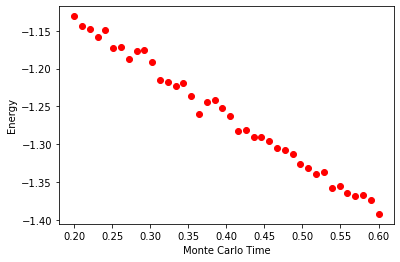

In [182]:
plt.plot(np.linspace(0.2,0.6,40),et,'ro')
plt.xlabel("Monte Carlo Time")
plt.ylabel("Energy")

Text(0, 0.5, 'Magnetization')

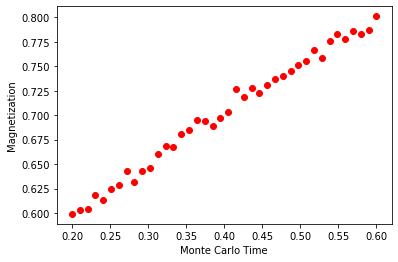

In [183]:
plt.plot(np.linspace(0.2,0.6,40),np.abs(mt),'ro')
plt.xlabel("Monte Carlo Time")
plt.ylabel("Magnetization")

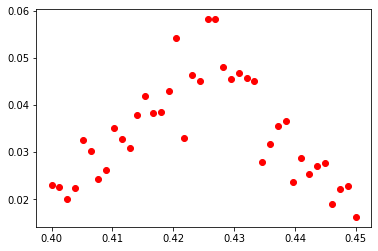

In [15]:
plt.plot(np.linspace(0.4,0.45,40),ct,'ro') #30 x 30 lattice

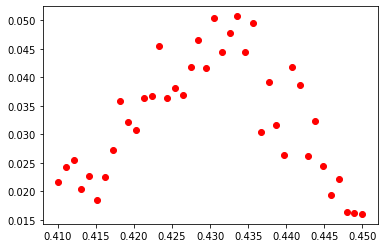

In [49]:
plt.plot(np.linspace(0.41,0.45,40),ct40,'ro')

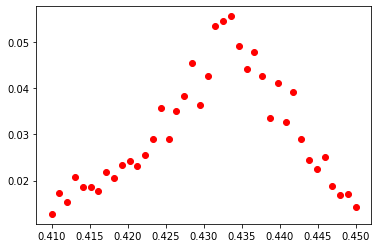

In [24]:
plt.plot(np.linspace(0.41,0.45,40),ct50,'ro')

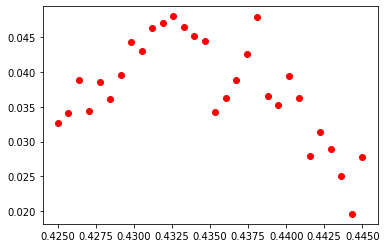

In [33]:
plt.plot(np.linspace(0.425,0.445,30),ct65,'ro')

In [ ]:
5

(0.428, 0.442)

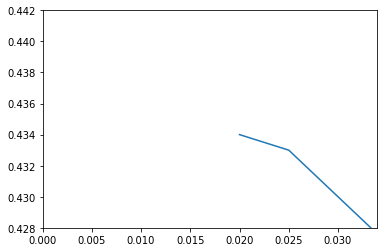

In [28]:
plt.plot([1/50,1/40,1/30],[.434, .433, .4280])
plt.xlim([0,.034])
plt.ylim([.428,.442])

In [ ]:
def mc_wolff(lattice, beta, nsteps):
    lattice = lattice.copy()
    p_accept = 1.0 - np.exp(-2*beta)
    for n in range(nsteps):        
        i,j = tuple(rng.integers(len(lattice), size = 2))
        init_spin = lattice[i,j]
        cluster = np.array([])
        while 1:
            if lattice[i-1,j]==init_spin and not np.any(